# MONAI : Tutorial : microscopy
## Multi-channel / Multi-spectral Microscopy Classification

参照URL:
https://github.com/Project-MONAI/tutorials/blob/main/microscopy/multichannel_microscopy_classification.ipynb

ステップ:
- 訓練/検証/テスト用の6チャネル蛍光顕微鏡データセットを読み込む.
- 6チャネルマルチスペクトル画像データの前処理に, MONAIのtransformsを使用する.
- 分類にMONAIのDenseNet169(3チャンネル/RGBのImageNetデータで事前学習済み)を使用する.
- 典型的なPyTorchの学習ループでモデルを学習する.
- データセットの少量のテストデータを用いてホールドアウト法で評価する.

## 0. 準備

In [25]:
# パッケージのインポート
import warnings
warnings.simplefilter('ignore')

import os
import pprint
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import Dataset, CacheDataset, DataLoader, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet169
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    ConcatItemsd,
    LoadImaged,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    ScaleIntensityRangePercentilesd,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.2.dev2302
Numpy version: 1.24.1
Pytorch version: 1.12.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: /home/aska/anaconda3/envs/monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## 1. データの可視化
### 1. 1 データセットの準備

In [26]:
# Rxrx1サブセットデータのダウンロード
url = 'https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/rxrx1_subset_monai.zip'
download_and_extract(
    url,
    filepath='./rxrx1_subset_monai.zip',
    output_dir='.',
    hash_val='5eea02f6b0a6d8cbce6ad66949257438'
)

2023-01-27 14:42:38,319 - INFO - Verified 'rxrx1_subset_monai.zip', md5: 5eea02f6b0a6d8cbce6ad66949257438.
2023-01-27 14:42:38,322 - INFO - File exists: rxrx1_subset_monai.zip, skipped downloading.
2023-01-27 14:42:38,325 - INFO - Non-empty folder exists in rxrx1_subset_monai, skipped extracting.


In [27]:
# データ情報の読み込み
data_dir = './rxrx1_subset_monai'

all_df = pd.read_csv(os.path.join(data_dir, './metadata.csv'))
all_df.head()

,original_row_index,site_id,well_id,cell_type,dataset,experiment,plate,well,site,well_type,sirna,sirna_id
0,45589,HEPG2-01_3_C15_2,HEPG2-01_3_C15,HEPG2,train,HEPG2-01,3,C15,2,positive_control,s15652,1114
1,59951,HEPG2-07_2_H02_2,HEPG2-07_2_H02,HEPG2,train,HEPG2-07,2,H02,2,treatment,s195435,683
2,48708,HEPG2-02_4_D13_1,HEPG2-02_4_D13,HEPG2,train,HEPG2-02,4,D13,1,treatment,s20197,85
3,46896,HEPG2-02_1_E09_1,HEPG2-02_1_E09,HEPG2,train,HEPG2-02,1,E09,1,treatment,s27069,313
4,60402,HEPG2-07_3_D09_1,HEPG2-07_3_D09,HEPG2,train,HEPG2-07,3,D09,1,treatment,s18250,405


In [28]:
train_df = all_df.loc[all_df.dataset == 'train', :].reset_index()
test_df = all_df.loc[all_df.dataset == 'test', :].reset_index()
print(len(train_df.index), len(test_df.index))

1000 200


In [29]:
class_map = {c: idx for idx, c in enumerate(train_df.cell_type.unique())}
class_map_inv = {idx: c for idx, c in enumerate(train_df.cell_type.unique())}
num_classes = len(class_map)
class_names = list(class_map.keys())

print(train_df.columns)

Index(['index', 'original_row_index', 'site_id', 'well_id', 'cell_type',
       'dataset', 'experiment', 'plate', 'well', 'site', 'well_type', 'sirna',
       'sirna_id'],
      dtype='object')


In [30]:
# データリスト作成
datalists = []

for df in [train_df, test_df]:
    datalist = []
    for row in range(df.shape[0]):
        d = {}
        s = df.loc[row, :]
        filepaths = []
        for c in [1, 2, 3, 4, 5, 6]: # plate no.
            subpath = os.path.join('images', s.experiment, f'Plate{s.plate}')
            fn = f'{s.well}_s{s.site}_w{c}.png'
            d[f'c{c}'] = os.path.join(data_dir, subpath, fn)
        d['label'] = class_map[s.cell_type]
        datalist.append(d)
    datalists.append(datalist)

datalist_train, datalist_test = tuple(datalists)

# print 3 example train samples
pp = pprint.PrettyPrinter()
pp.pprint(datalist_train[:3])

[{'c1': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w1.png',
  'c2': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w2.png',
  'c3': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w3.png',
  'c4': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w4.png',
  'c5': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w5.png',
  'c6': './rxrx1_subset_monai/images/HEPG2-01/Plate3/C15_s2_w6.png',
  'label': 0},
 {'c1': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w1.png',
  'c2': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w2.png',
  'c3': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w3.png',
  'c4': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w4.png',
  'c5': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w5.png',
  'c6': './rxrx1_subset_monai/images/HEPG2-07/Plate2/H02_s2_w6.png',
  'label': 0},
 {'c1': './rxrx1_subset_monai/images/HEPG2-02/Plate4/D13_s1_w1.png',
  'c2': './rxrx1_subset_monai/images/HEPG2-02/Plate4/D13_s1_w2.png',
  'c

### 1. 2 データ可視化

In [31]:
# 6チャンネル画像をRGB画像に変換
def img_6to3_channel(img6ch):
    img = torch.zeros((img6ch.shape[1], img6ch.shape[2], 3))
    # nuclei -> blue
    img[:, :, 2] += img6ch[0, :, :]
    # endoplasmic reticuli -> green
    img[:, :, 1] += img6ch[1, :, :]
    # actin -> red
    img[:, :, 0] += img6ch[2, :, :]
    # nucleoli -> cyan
    img[:, :, 1] += img6ch[3, :, :]
    img[:, :, 2] += img6ch[3, :, :]
    # mitochondria -> magenta
    img[:, :, 0] += img6ch[4, :, :]
    img[:, :, 2] += img6ch[4, :, :]
    # golgi apparatus -> yellow
    img[:, :, 0] += img6ch[5, :, :]
    img[:, :, 1] += img6ch[5, :, :]
    # nomalize RGB channels
    img = img / 3.0
    return img

In [32]:
# 正規化なしでデータ表示
# 乱数シードの設定
set_determinism(0)

transforms_visualize = Compose(
    [
        LoadImaged(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], image_only=True),
        EnsureChannelFirstd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6']),
        ConcatItemsd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], name='image', dim=0),
    ]
)

In [33]:
batch_size_viz = 4
viz_ds = Dataset(datalist_train, transform=transforms_visualize)
viz_loader = DataLoader(viz_ds, batch_size=batch_size_viz, shuffle=True, num_workers=0)

batch_data = next(iter(viz_loader))

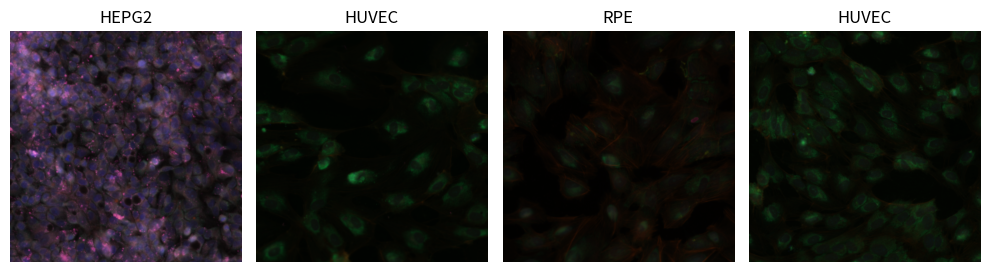

In [34]:
fig, axs = plt.subplots(1, batch_size_viz, figsize=(10, 10 * batch_size_viz), dpi=100)

for idx, img6ch in enumerate(batch_data['image']):
    axs[idx].imshow(img_6to3_channel(img6ch) / 255.)
    axs[idx].set_axis_off()
    axs[idx].set_title(class_map_inv[int(batch_data['label'][idx])])

fig.set_tight_layout(True)
plt.show()

In [35]:
# 正規化ありでデータ表示
# 乱数シードの設定
set_determinism(0)

transforms_visualize = Compose(
    [
        LoadImaged(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], image_only=True),
        EnsureChannelFirstd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6']),
        ScaleIntensityRangePercentilesd(keys=['c1', 'c2', 'c3', 'c4', 'c5','c6'],
                                        lower=1.0, upper=99.0,
                                        b_min=0.0, b_max=1.0,
                                        clip=True),
        ConcatItemsd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], name='image', dim=0),
    ]
)


In [36]:
batch_size_viz = 4
viz_ds = Dataset(datalist_train, transform=transforms_visualize)
viz_loader = DataLoader(viz_ds, batch_size=batch_size_viz, shuffle=True, num_workers=0)

batch_data = next(iter(viz_loader))

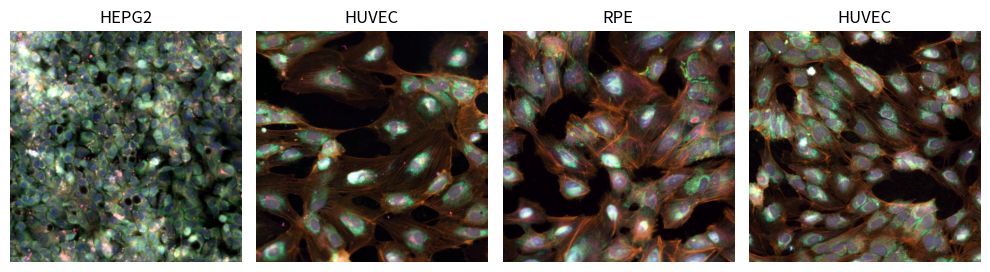

In [37]:
fig, axs = plt.subplots(1, batch_size_viz, figsize=(10, 10 * batch_size_viz), dpi=100)

for idx, img6ch in enumerate(batch_data['image']):
    axs[idx].imshow(img_6to3_channel(img6ch))
    axs[idx].set_axis_off()
    axs[idx].set_title(class_map_inv[int(batch_data['label'][idx])])
    
fig.set_tight_layout(True)
fig.show()

## 2. 学習
### 2.1 データセット, データローダ

In [38]:
# 乱数シードの設定
set_determinism(seed=2023)

In [39]:
transforms_train = Compose(
    [
        LoadImaged(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], image_only=True),
        EnsureChannelFirstd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6']),
        ScaleIntensityRangePercentilesd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], 
                                       lower=1.0, upper=99.0,
                                       b_min=0.0, b_max=1.0,
                                       clip=True),
        ConcatItemsd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], name='image', dim=0),
        EnsureTyped(keys=['image', 'label'], track_meta=False),
        RandRotate90d(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], prob=0.75),
        RandFlipd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], spatial_axis=[0, 1], prob=0.5),
        RandZoomd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

In [40]:
transforms_val = Compose(
    [
        LoadImaged(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], image_only=True),
        EnsureChannelFirstd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6']),
        ScaleIntensityRangePercentilesd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],
                                       lower=1.0, upper=99.0,
                                       b_min=0.0, b_max=1.0,
                                       clip=True),
        ConcatItemsd(keys=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], name='image', dim=0),
    ]
)

In [41]:
y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_classes)])

In [42]:
batch_size_train = 8
train_ds = CacheDataset(datalist_train, transform=transforms_train, num_workers=0)
train_loader = ThreadDataLoader(train_ds, batch_size=batch_size_train, shuffle=True)

Loading dataset: 100%|██████████████████████| 1000/1000 [02:52<00:00,  5.79it/s]


### 2.2 モデル定義

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
model = DenseNet169(
    spatial_dims=2, 
    in_channels=6, 
    out_channels=num_classes, 
    pretrained=True
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [45]:
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

### 2.3 モデル学習

In [46]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# epochループ
epoch_len = len(train_ds) // train_loader.batch_size
for epoch in range(max_epochs):
    print('-' * 10)
    print(f'epoch {epoch + 1}/{max_epochs}')
    model.train()
    epoch_loss = 0
    step = 0
    
    # mini batchループ
    for batch_data in train_loader:
        step += 1
        inputs = batch_data['image'].to(device)
        labels = batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f'{step}/{epoch_len}, '
            f'train_loss: {loss.item():.4f}'
        )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f'epoch {epoch + 1} average loss: {epoch_loss:.4f}')

----------
epoch 1/4
1/125, train_loss: 1.4602
2/125, train_loss: 1.3346
3/125, train_loss: 1.4589
4/125, train_loss: 1.3876
5/125, train_loss: 1.4811
6/125, train_loss: 1.3939
7/125, train_loss: 1.1334
8/125, train_loss: 1.3057
9/125, train_loss: 1.6422
10/125, train_loss: 1.2972
11/125, train_loss: 1.2122
12/125, train_loss: 1.2351
13/125, train_loss: 1.3745
14/125, train_loss: 1.3855
15/125, train_loss: 1.2659
16/125, train_loss: 1.4041
17/125, train_loss: 1.3735
18/125, train_loss: 1.4180
19/125, train_loss: 1.3558
20/125, train_loss: 1.3868
21/125, train_loss: 1.1918
22/125, train_loss: 1.4569
23/125, train_loss: 1.6183
24/125, train_loss: 1.2944
25/125, train_loss: 1.1889
26/125, train_loss: 1.1172
27/125, train_loss: 1.3363
28/125, train_loss: 1.1499
29/125, train_loss: 1.2484
30/125, train_loss: 1.1799
31/125, train_loss: 1.0969
32/125, train_loss: 1.3724
33/125, train_loss: 1.1730
34/125, train_loss: 1.0543
35/125, train_loss: 1.1404
36/125, train_loss: 0.9548
37/125, train_lo

50/125, train_loss: 0.1452
51/125, train_loss: 0.3342
52/125, train_loss: 0.4226
53/125, train_loss: 0.3001
54/125, train_loss: 0.2718
55/125, train_loss: 0.1372
56/125, train_loss: 0.1792
57/125, train_loss: 0.6681
58/125, train_loss: 0.0942
59/125, train_loss: 0.0412
60/125, train_loss: 0.1946
61/125, train_loss: 0.1960
62/125, train_loss: 0.1533
63/125, train_loss: 0.0587
64/125, train_loss: 0.3475
65/125, train_loss: 0.3144
66/125, train_loss: 0.0927
67/125, train_loss: 0.0521
68/125, train_loss: 0.1053
69/125, train_loss: 0.1931
70/125, train_loss: 0.0774
71/125, train_loss: 0.3176
72/125, train_loss: 0.4149
73/125, train_loss: 0.3368
74/125, train_loss: 0.1571
75/125, train_loss: 0.2677
76/125, train_loss: 0.2339
77/125, train_loss: 0.3851
78/125, train_loss: 0.2276
79/125, train_loss: 0.1681
80/125, train_loss: 0.1746
81/125, train_loss: 0.0707
82/125, train_loss: 0.4898
83/125, train_loss: 0.1317
84/125, train_loss: 0.2995
85/125, train_loss: 0.1008
86/125, train_loss: 0.3016
8

## 3. 評価

In [47]:
batch_size_test = 32

test_ds = Dataset(datalist_test, transform=transforms_val)
test_loader = DataLoader(test_ds, batch_size=batch_size_test, shuffle=False, num_workers=4)

In [48]:
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['image'].to(device),
            test_data['label'].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       HEPG2     0.9434    1.0000    0.9709        50
       HUVEC     0.9800    0.9800    0.9800        50
         RPE     0.9615    1.0000    0.9804        50
        U2OS     1.0000    0.9000    0.9474        50

    accuracy                         0.9700       200
   macro avg     0.9712    0.9700    0.9697       200
weighted avg     0.9712    0.9700    0.9697       200

